## **Introduction**

This notebook investigates **claim + evidence** veracity prediction on the **X-fact** dataset as part of a broader study on misinformation detection across multiple benchmarks. The goal is to evaluate how different modeling approaches capture the linguistic cues associated with factual correctness. The workflow includes dataset cleaning, majority-vote label consolidation, decontamination of train/validation/test splits, and systematic comparison of three baselines: TF–IDF + Complement Naive Bayes, FastText embeddings with a multilayer perceptron, and a fine-tuned XLM-RoBERTa classifier.


In [ ]:
!pip install -q datasets
!pip install -q transformers
!pip install -q gensim
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset, Dataset as HfDataset
import gensim
from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, average_precision_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt
import evaluate
import random
from pprint import pprint
import os
import nltk
import gensim.downloader as api

pd.set_option('future.no_silent_downcasting', True)

nltk.download("punkt")
nltk.download("punkt_tab")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

## **Dataset and Pre-processing**

The **X-Fact** subset of the ComplexDataLab Misinfo_Datasets is used, which contains multilingual fact-checking claims annotated as *false*, *true*, or *unknown*. Each example includes a claim text, 5 evidence, language, and multiple additional metadata fields.

The preprocessing pipeline consists of:
- Keeping only the `claim`, `veracity`, `language` and five `evidence` columns.
- Replacing literal `"na"` strings with missing values and dropping empty rows.
- Combining the `claim` and  the five `evidence`columns into a `combined_text` column.
- Collapsing multiple annotations per `combined_text` using a majority vote (threshold 0.7).
- Removing any `combined_text` that appear across train/validation/test splits to avoid leakage.

After preprocessing, the final dataset contains **25,892** training examples, **3,682** validation examples, and **7,397** test examples, with no overlapping claims between splits.


In [ ]:
SUBSET_NAME = "x_fact"
TEXT_COL = "combined_text"
LABEL_COL = "veracity"
LANGUAGE_COL = "language"
EVIDENCE_COLS = [f"evidence_{i}" for i in range(1, 6)]

In [ ]:
ds = load_dataset("ComplexDataLab/Misinfo_Datasets", SUBSET_NAME)
ds

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

x_fact/x_fact_train.parquet:   0%|          | 0.00/32.7M [00:00<?, ?B/s]

x_fact/x_fact_test.parquet:   0%|          | 0.00/9.43M [00:00<?, ?B/s]

x_fact/x_fact_validation.parquet:   0%|          | 0.00/4.75M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26413 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7547 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3774 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['claim', 'veracity', 'dataset', 'label', 'question', 'answer', 'positive_evidence_text', 'positive_evidence_title', 'negative_evidence_text', 'negative_evidence_title', 'split', 'source', 'source_url', 'article_content', 'article_headline', 'author', 'initial_claim', 'fact1', 'fact2', 'fact3', 'fact4', 'num_hops', 'date', 'similarity', 'like_count', 'retweet_count', 'tweet_text', 'tweet_label', 'evidence_1', 'link_evidence_1', 'source_evidence_1', 'fact_check_source', 'image', 'article_title', 'meta_data_twitter_site', 'meta_data_og_image', 'source_id', 'fact_check_url', 'language', 'tweet_id', 'subject', 'revelant_to_vaccines', 'mention_non_covid_vaccine', 'contain_misinfo_about_vaccine', 'dominant_sentiment_tweet', 'dominant_sentiment_vaccine', 'country', 'image_id', 'image_url', 'event', 'label_2', 'pos_variations', 'Q1_contain_factual_claim', 'Q2_contain_false_info', 'Q3_impact_on_public', 'Q4_harmful_to_society', 'Q5_factchecke

In [ ]:
def hf_clean(ds_split, claim_col="claim", label_col=LABEL_COL, language_col=LANGUAGE_COL, evidence_cols=EVIDENCE_COLS, combined_col=TEXT_COL):
    df = ds_split.to_pandas()

    df = df.replace("na", np.nan)

    keep_cols = [claim_col, label_col, language_col] + evidence_cols
    keep_cols = [c for c in keep_cols if c in df.columns]
    df = df[keep_cols]

    df = df.dropna(subset=[claim_col, label_col, language_col])

    df[claim_col]    = df[claim_col].astype(str).str.strip()
    df[label_col]    = df[label_col].astype(str).str.strip()
    df[language_col] = df[language_col].astype(str).str.strip()

    def combine_row(row):
        parts = [row[claim_col]]
        ev_texts = []
        for col in evidence_cols:
            if col in row.index and pd.notna(row[col]):
                s = str(row[col]).strip()
                if s:
                    ev_texts.append(s)
        if ev_texts:
            return row[claim_col] + " [SEP] " + " [SEP] ".join(ev_texts)
        else:
            return row[claim_col]

    df[combined_col] = df.apply(combine_row, axis=1)
    df = df[df[combined_col].str.strip() != ""]

    return df


In [ ]:
def collapse_by_majority_label(df, text_col=TEXT_COL, label_col=LABEL_COL, language_col=LANGUAGE_COL, min_majority=0.7):
    # count labels per claim
    label_counts = (
        df.groupby([text_col, label_col])
          .size()
          .rename("count")
          .reset_index()
    )

    # for each claim, find majority label and its proportion
    total_per_claim = label_counts.groupby(text_col)["count"].transform("sum")
    label_counts["prop"] = label_counts["count"] / total_per_claim

    majority = (label_counts.sort_values("prop", ascending=False)
                           .drop_duplicates(subset=[text_col]))

    # keep only claims where majority label has enough support
    majority = majority[majority["prop"] >= min_majority]

    clean_df = majority[[text_col, label_col]].copy()
    languages = df[[text_col, language_col]].drop_duplicates(subset=[text_col])
    clean_df = clean_df.merge(languages, on=text_col, how="left")

    return clean_df

In [ ]:
clean_train_df = hf_clean(ds["train"])
clean_val_df = hf_clean(ds["validation"])
clean_test_df = hf_clean(ds["test"])

In [ ]:
train_df = collapse_by_majority_label(clean_train_df)
val_df = collapse_by_majority_label(clean_val_df)
test_df = collapse_by_majority_label(clean_test_df)

In [ ]:
print("Original train size:", len(clean_train_df))
print("After collapsing, train size:", len(train_df))
print("Original val size  :", len(clean_val_df))
print("After collapsing, val size  :", len(val_df))
print("Original test size :", len(clean_test_df))
print("After collapsing, test size :", len(test_df))

Original train size: 25923
After collapsing, train size: 25892
Original val size  : 3695
After collapsing, val size  : 3695
Original test size : 7413
After collapsing, test size : 7407


In [ ]:
train_claims = set(train_df[TEXT_COL])
val_claims   = set(val_df[TEXT_COL])
test_claims  = set(test_df[TEXT_COL])

# Pairwise overlaps
train_val_overlap  = train_claims & val_claims
train_test_overlap = train_claims & test_claims
val_test_overlap   = val_claims & test_claims

# Triple overlap (in all three splits)
all_three_overlap = train_claims & val_claims & test_claims

print("Unique claims per split:")
print(f"  Train: {len(train_claims)}")
print(f"  Val  : {len(val_claims)}")
print(f"  Test : {len(test_claims)}\n")

print("Overlapping claims:")
print(f"  Train ∩ Val      : {len(train_val_overlap)}")
print(f"  Train ∩ Test     : {len(train_test_overlap)}")
print(f"  Val ∩ Test       : {len(val_test_overlap)}")
print(f"  Train ∩ Val ∩ Test: {len(all_three_overlap)}")


Unique claims per split:
  Train: 25892
  Val  : 3695
  Test : 7407

Overlapping claims:
  Train ∩ Val      : 13
  Train ∩ Test     : 9
  Val ∩ Test       : 1
  Train ∩ Val ∩ Test: 0


In [ ]:
def remove_split_duplicates(train_df, val_df, test_df, text_col=TEXT_COL):
    """
    Remove examples from val and test sets that appear in train set
    """
    # Get unique claims from train set
    train_claims = set(train_df[text_col])

    # Remove duplicates from validation set
    val_df_clean = val_df[~val_df[text_col].isin(train_claims)].copy()

    # Remove duplicates from test set
    test_df_clean = test_df[~test_df[text_col].isin(train_claims)].copy()

    # Also remove any overlap between val and test
    val_claims_clean = set(val_df_clean[text_col])
    test_df_clean = test_df_clean[~test_df_clean[text_col].isin(val_claims_clean)]

    print(f"Removed {len(val_df) - len(val_df_clean)} duplicates from validation set")
    print(f"Removed {len(test_df) - len(test_df_clean)} duplicates from test set")
    print(f"Final sizes - Train: {len(train_df)}, Val: {len(val_df_clean)}, Test: {len(test_df_clean)}")

    return val_df_clean, test_df_clean

In [ ]:
val_df, test_df = remove_split_duplicates(train_df, val_df, test_df)

print("\nAfter deduplication:")
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Removed 13 duplicates from validation set
Removed 10 duplicates from test set
Final sizes - Train: 25892, Val: 3682, Test: 7397

After deduplication:
Train: 25892, Val: 3682, Test: 7397


In [ ]:
# Verify no overlaps remain
train_claims_final = set(train_df[TEXT_COL])
val_claims_final = set(val_df[TEXT_COL])
test_claims_final = set(test_df[TEXT_COL])

print(f"Train ∩ Val: {len(train_claims_final & val_claims_final)}")
print(f"Train ∩ Test: {len(train_claims_final & test_claims_final)}")
print(f"Val ∩ Test: {len(val_claims_final & test_claims_final)}")

Train ∩ Val: 0
Train ∩ Test: 0
Val ∩ Test: 0


In [ ]:
print("\nLabel values in train:")
print(train_df[LABEL_COL].value_counts())


Label values in train:
veracity
false      15697
true        8005
unknown     2190
Name: count, dtype: int64


In [ ]:
# unique labels from train
unique_labels = sorted(train_df[LABEL_COL].unique())
label2id = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}

print("Label mapping:")
print(label2id)

Label mapping:
{'false': 0, 'true': 1, 'unknown': 2}


In [ ]:
# Add numeric labels
train_df["labels"] = train_df[LABEL_COL].map(label2id)
val_df["labels"] = val_df[LABEL_COL].map(label2id)
test_df["labels"] = test_df[LABEL_COL].map(label2id)

In [ ]:
print(train_df["combined_text"][1])

" 'denali' is the kenyan word for 'black power.' " [SEP] aug 30, 2015 ... second, “denali” does not mean “black power” in either english or swahili. the  word for black in swahili is “mweusi” and the word for power is ... [SEP] sep 1, 2015 ... we need a black power mountain ... a meme spread across facebook timelines  alleging that “denali” was a “kenyan word” for black power. [SEP] sep 3, 2015 ... soon after, a meme began circulating on social media claiming denali as the  kenyan word for “black power.” the meme's false but viral ... [SEP] sep 3, 2015 ... and then there was the internet rumor that “denali” was the “kenyan” word for  black power (it isn't), not to mention an anagram for “denial,” ... [SEP] sep 1, 2015 ... after the white house announced it would change the name of mt. mckinley,  conservatives spread a meme claiming "denali" was a kenyan ...


In [ ]:
train_df.head()

## **Evaluation Utilities**


- **Confusion matrices** (raw counts + normalized):
  - Show which pairs of labels (`false`, `true`, `unknown`) are most frequently confused.
- **Macro-F1**:
  - Averages F1 across classes and is robust to class imbalance.
- **Macro and Micro AUPRC**:
  - Evaluate how well the model’s **probability scores** rank the true labels.
- **Expected Calibration Error (ECE)**:
  - Measures how well predicted probabilities reflect actual accuracy (e.g., “are 0.8-confidence predictions correct ~80% of the time?”).
- **Error tables**:
  - For each misclassified example, store:
    - the original text,
    - ground-truth label,
    - predicted label,
    - model confidence and per-class probabilities.

These utilities are shared by all models (Complement Naive Bayes, FastText+MLP, XLM-R) so their performance and typical errors can be directly compared.


In [ ]:
def plot_confusion(y_true, probs, id2label=id2label, normalize=False, title=None):
    """
    y_true: ground truth labels (numpy array)
    probs: predicted probabilities from model (numpy array)
    normalize: True → show percentages, False → raw counts
    """
    preds = probs.argmax(axis=1)

    cm = confusion_matrix(y_true, preds, normalize='true' if normalize else None)

    labels = [id2label[i] for i in sorted(id2label.keys())]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    if title:
        plt.title(title)
    plt.show()

    return cm

In [ ]:
CLASS_IDS = sorted(id2label.keys())

def compute_auprc(probs, y_true, class_ids=CLASS_IDS):
    """
    probs: [N, num_classes]
    y_true: [N] (int labels)
    """
    y_bin = label_binarize(y_true, classes=class_ids)  # [N, C]
    auprc_macro = average_precision_score(y_bin, probs, average="macro")
    auprc_micro = average_precision_score(y_bin, probs, average="micro")
    return auprc_macro, auprc_micro


def compute_ece(probs, y_true, n_bins=15):
    """
    Simple Expected Calibration Error (ECE).
    probs: [N, num_classes]
    y_true: [N]
    """
    preds = probs.argmax(axis=1)
    confidences = probs.max(axis=1)
    correct = (preds == y_true).astype(float)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        mask = (confidences > bins[i]) & (confidences <= bins[i+1])
        if not np.any(mask):
            continue
        bin_conf = confidences[mask].mean()
        bin_acc  = correct[mask].mean()
        bin_frac = mask.mean()
        ece += bin_frac * abs(bin_conf - bin_acc)

    return float(ece)

In [ ]:
def evaluate_probs(probs, y_true, split_name, class_ids, id2label, n_bins=15):
    """
    probs: [N, num_classes]
    y_true: [N] int labels
    class_ids: list of class indices (e.g., CLASS_IDS = sorted(id2label.keys()))
    id2label: dict mapping id -> label string
    """
    preds = probs.argmax(axis=1)

    # Macro-F1
    macro_f1 = f1_score(y_true, preds, average="macro")

    # AUPRC
    auprc_macro, auprc_micro = compute_auprc(probs, y_true, class_ids=class_ids)

    # ECE
    ece = compute_ece(probs, y_true, n_bins=n_bins)

    print(f"\n=== {split_name} ===")
    print("Macro-F1     :", macro_f1)
    print("Macro AUPRC  :", auprc_macro)
    print("Micro AUPRC  :", auprc_micro)
    print("ECE          :", ece)
    print()
    print(
        classification_report(
            y_true,
            preds,
            target_names=[id2label[i] for i in class_ids],
            zero_division=0,
        )
    )

    metrics = {
        "macro_f1": macro_f1,
        "auprc_macro": auprc_macro,
        "auprc_micro": auprc_micro,
        "ece": ece,
    }

    return metrics, preds

In [ ]:
def evaluate_sklearn_clf(model, X, y, split_name,
                         class_ids=CLASS_IDS, id2label=id2label, n_bins=15):
    """
    Evaluate any sklearn classifier with predict_proba.
    Returns (metrics_dict, probs, preds).
    """
    probs = model.predict_proba(X)  # [N, C]
    metrics, preds = evaluate_probs(
        probs, y, split_name,
        class_ids=class_ids,
        id2label=id2label,
        n_bins=n_bins
    )
    return metrics, probs, preds

In [ ]:
def make_error_table(
    probs,
    y_true,
    texts,
    class_ids,
    id2label,
    languages,
    split_name,
    model_name,
):
    """
    Build a DataFrame of misclassified examples for X-Fact ONLY.

    probs: [N, C] numpy array of predicted probabilities
    y_true: [N] numpy array of int labels
    texts: list of raw texts (len N)
    languages: list of languages (len N)
    split_name: "train" / "val" / "test"
    model_name: "TFIDF+NB" / "FT+MLP" / "XLM-R"
    """
    preds = probs.argmax(axis=1)
    confs = probs.max(axis=1)

    rows = []
    for i, (p, gt, pred, conf, text, lang) in enumerate(
        zip(probs, y_true, preds, confs, texts, languages)
    ):
        if gt == pred:
            continue  # keep only misclassified examples

        row = {
            "idx": i,
            "text": text,
            "actual": id2label[int(gt)],
            "pred": id2label[int(pred)],
            "conf": float(conf),
            "language": lang,
            "split": split_name,
            "model": model_name,
        }

        # Per-class probabilities
        for c in class_ids:
            row[f"p_{id2label[c]}"] = float(p[c])

        rows.append(row)

    return pd.DataFrame(rows)


def show_errors(df, actual_label, pred_label, k=5, sort_by_conf=True):
    """
    Inspect misclassifications:
    actual_label, pred_label: strings like "false", "true", "unknown"
    """
    subset = df[(df["actual"] == actual_label) & (df["pred"] == pred_label)]

    if subset.empty:
        print(f"No examples for actual={actual_label}, pred={pred_label}")
        return

    if sort_by_conf:
        subset = subset.sort_values("conf", ascending=False)

    print(f"\n=== {len(subset)} examples where actual={actual_label}, pred={pred_label} ===\n")
    for _, row in subset.head(k).iterrows():
        print(f"[idx={row['idx']}] conf={row['conf']:.3f}")
        print("LANG:", row["language"])
        print("TEXT:", row["text"])
        print("ACTUAL:", row["actual"], "| PRED:", row["pred"])
        print("-" * 80)

## **TF-IDF + Complement Naive Bayes**

The first model is a **TF–IDF + Complement Naive Bayes** classifier:

- Claims are represented using **unigrams and bigrams** (`ngram_range=(1, 2)`).
- The vocabulary is capped at **100,000 features** and pruned with `min_df=2`.
- **ComplementNB** is well-suited for text classification with **imbalanced classes**.

In [ ]:
X_train = train_df[TEXT_COL].tolist()
y_train = train_df["labels"].to_numpy()

X_val   = val_df[TEXT_COL].tolist()
y_val   = val_df["labels"].to_numpy()

X_test  = test_df[TEXT_COL].tolist()
y_test  = test_df["labels"].to_numpy()

In [ ]:
print(X_train[0])
print(y_train[0])

👆this little beautiful girl was seen in mangalore with a group of tamil beggars.please forward until it reaches the right parent and she is identified. she knows her name & says she is sonal bipin patel.please post this photo on all your groups.the beggars say she was found in a train coming from mumbai.may be she can get her life back. 🙏 [SEP] jul 22, 2019 â€” no, this girl wasn't with 'tamil beggars', she's from bangladesh. as can be seen, the currency notes ... the beautiful girl was seen in mangalore with tamil beggars pls forward until it reaches the right parent and she is identified. please post this photo on all your groups.............found from a train comingâ ... [SEP] this beautiful girl was seen in mangalore with a group of tamil beggars [SEP] the missing little girl was found in mangalore with tamil beggars. [SEP] dec 10, 2019 â€” her name is sonal bipin patel, â€� the text read. app-facebook. saiyed ali imran. about 11 months ago. please help me to get this baby to the r

In [ ]:
tfidf_nb_clf = Pipeline(
    [
        ("tfidf", TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=100_000,
            min_df=2
        )),
        ("cnb", ComplementNB())
    ]
)

In [ ]:
tfidf_nb_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=100000, min_df=2,
                                 ngram_range=(1, 2))),
                ('cnb', ComplementNB())])

In [ ]:
metrics_train_nb, train_probs_nb, train_preds_nb = evaluate_sklearn_clf(
    tfidf_nb_clf, X_train, y_train, "Train (TFIDF+NB)"
)
metrics_val_nb,   val_probs_nb,   val_preds_nb   = evaluate_sklearn_clf(
    tfidf_nb_clf, X_val,   y_val,   "Validation (TFIDF+NB)"
)
metrics_test_nb,  test_probs_nb,  test_preds_nb  = evaluate_sklearn_clf(
    tfidf_nb_clf, X_test,  y_test,  "Test (TFIDF+NB)"
)


=== Train (TFIDF+NB) ===
Macro-F1     : 0.5879542514850162
Macro AUPRC  : 0.7279699131210071
Micro AUPRC  : 0.7529487464791547
ECE          : 0.07789102173859935

              precision    recall  f1-score   support

       false       0.83      0.63      0.71     15697
        true       0.65      0.66      0.65      8005
     unknown       0.27      0.74      0.40      2190

    accuracy                           0.65     25892
   macro avg       0.58      0.67      0.59     25892
weighted avg       0.73      0.65      0.67     25892


=== Validation (TFIDF+NB) ===
Macro-F1     : 0.4974215601803533
Macro AUPRC  : 0.5289202816370929
Micro AUPRC  : 0.6825907656571937
ECE          : 0.09912038713622558

              precision    recall  f1-score   support

       false       0.81      0.60      0.69      2256
        true       0.52      0.50      0.51      1140
     unknown       0.19      0.61      0.29       286

    accuracy                           0.57      3682
   macro avg  

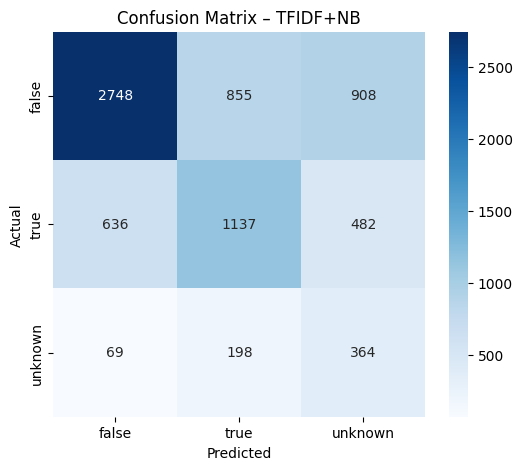

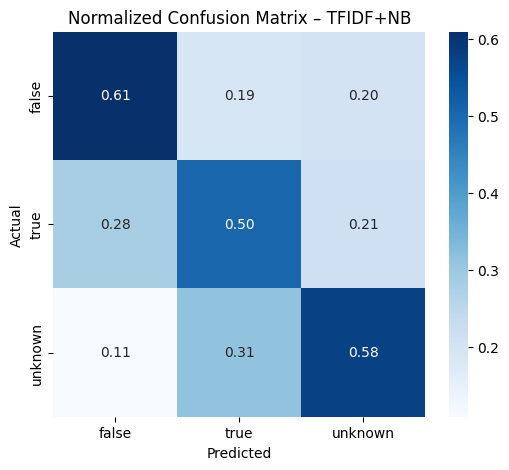

In [ ]:
cm_nb = plot_confusion(
    y_true=y_test,
    probs=test_probs_nb,
    title="Confusion Matrix – TFIDF+NB"
)

cm_nb_norm = plot_confusion(
    y_true=y_test,
    probs=test_probs_nb,
    normalize=True,
    title="Normalized Confusion Matrix – TFIDF+NB"
)

In [ ]:
test_langs = test_df[LANGUAGE_COL].tolist()

errors_nb_test = make_error_table(
    probs=test_probs_nb,
    y_true=y_test,
    texts=X_test,
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_langs,
    split_name="test",
    model_name="TFIDF+NB"
)

In [ ]:
print("Total misclassified examples:", len(errors_nb_test))

Total misclassified examples: 3148


In [ ]:
errors_nb_test.head()

,idx,text,actual,pred,conf,language,split,model,p_false,p_true,p_unknown
0,1,„ქართული ოცნება“ მოვიდა კომუნალურების განახევრ...,true,unknown,0.406629,ka,test,TFIDF+NB,0.232429,0.360942,0.406629
1,4,„უნივერსიტეტებს დამოუკიდებლობა ეზღუდებათ“ [SEP...,unknown,true,0.553969,ka,test,TFIDF+NB,0.203816,0.553969,0.242214
2,6,"„უკვე ვასრულებთ ქალაქის გზების მოწესრიგებას, ე...",false,true,0.626109,ka,test,TFIDF+NB,0.170823,0.626109,0.203067
3,8,„სტატისტიკის დეპარტამენტის მონაცემების მიხედვი...,false,true,0.597008,ka,test,TFIDF+NB,0.163375,0.597008,0.239617
4,10,„სექტემბრიდან ათასობით ოჯახი [შშმ ბავშვები] ელ...,false,true,0.633065,ka,test,TFIDF+NB,0.159761,0.633065,0.207174


In [ ]:
output_dir = "/content/drive/MyDrive/misinfo_project"
os.makedirs(output_dir, exist_ok=True)

nb_errors_path = os.path.join(output_dir, "x_fact_c_e_nb_test_errors.csv")
errors_nb_test.to_csv(nb_errors_path, index=False)

print("Saved NB test errors to:", nb_errors_path)

Saved NB test errors to: /content/drive/MyDrive/misinfo_project/x_fact_c_e_nb_test_errors.csv


## **FastText Embeddings + MLP**

The second model is a **shallow neural model** that uses pre-trained **FastText** word embeddings combined with a small MLP:

1. **Tokenization & Embeddings**
   - Each claim is tokenized with `nltk.word_tokenize`.
   - **Only alphabetic** tokens are retained, and a **300-dimensional** FastText vector is obtained for each token.
   - Token vectors are **averaged** to produce a single sentence embedding per claim, followed by **L2-normalization**.

2. **MLP Architecture**
   - Input: 300-dim sentence vector.
   - Two hidden layers of size 256 and 128 with **ReLU** activations.
   - **Dropout (0.3)** after each hidden layer to reduce overfitting.
   - Output: 3-way softmax for `false`, `true`, `unknown`.

3. **Training Details**
   - Loss: Cross-entropy with **class weights** derived from the training label distribution to counter imbalance.
   - Optimizer: Adam with learning rate `1e-3`.
   - Strategy: up to **100 epochs** with **early stopping** based on validation macro-F1.

After training, the model is evaluated with the same metrics (Macro-F1, AUPRC, ECE, confusion matrices, error tables) to see how much a shallow neural approach improves over the lexical baseline.


In [ ]:
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
def tokenize(text):
    tokens = nltk.word_tokenize(text.lower())
    return [token for token in tokens if token.isalpha()]

In [ ]:
def sent_to_vec(tokens, model, dim):
    vecs = [model[w] for w in tokens if w in model]
    if not vecs:
        return np.zeros(dim, dtype=np.float32)
    return np.mean(vecs, axis=0)

def build_features(df, text_col, model, dim):
    X = np.vstack([
        sent_to_vec(tokenize(t), model, dim)
        for t in df[text_col].tolist()
    ])
    y = df["labels"].to_numpy()
    return X, y

In [ ]:
X_train_ft, y_train_ft = build_features(train_df, TEXT_COL, fasttext_model, 300)
X_val_ft, y_val_ft = build_features(val_df, TEXT_COL, fasttext_model, 300)
X_test_ft, y_test_ft = build_features(test_df, TEXT_COL, fasttext_model, 300)

In [ ]:
X_train_ft.shape

(25892, 300)

In [ ]:
class FT_Dataset(TorchDataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __getitems__(self, indices):
        return [self.__getitem__(i) for i in indices]

train_ds = FT_Dataset(X_train_ft, y_train_ft)
val_ds = FT_Dataset(X_val_ft, y_val_ft)
test_ds = FT_Dataset(X_test_ft, y_test_ft)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

In [ ]:
class FastTextMLP(nn.Module):
    def __init__(self, input_dim=300, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

In [ ]:
num_classes = len(CLASS_IDS)

class_counts = np.bincount(y_train, minlength=num_classes).astype(np.float32)
print("Counts:", class_counts)

class_weights = class_counts.sum() / (num_classes * class_counts)
print("Weights:", class_weights)

class_weights_t = torch.tensor(class_weights, dtype=torch.float32).to(device)

Counts: [15697.  8005.  2190.]
Weights: [0.54982907 1.0781595  3.9409437 ]


In [ ]:
model = FastTextMLP().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_t)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(y.cpu().numpy())
            total_loss += loss.item()
    return (total_loss / len(loader),
            np.vstack(all_probs),
            np.concatenate(all_labels))


In [ ]:
best_val_loss = float("inf")
patience = 5
wait = 0
EPOCHS = 100
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader)
    val_loss, val_probs, val_labels = eval_epoch(model, val_loader)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        best_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_state)

Epoch 01 | Train Loss: 0.9941 | Val Loss: 0.8859
Epoch 02 | Train Loss: 0.9359 | Val Loss: 0.8679
Epoch 03 | Train Loss: 0.9243 | Val Loss: 0.8598
Epoch 04 | Train Loss: 0.9152 | Val Loss: 0.8504
Epoch 05 | Train Loss: 0.9170 | Val Loss: 0.8520
Epoch 06 | Train Loss: 0.9097 | Val Loss: 0.8509
Epoch 07 | Train Loss: 0.9075 | Val Loss: 0.8483
Epoch 08 | Train Loss: 0.9079 | Val Loss: 0.8530
Epoch 09 | Train Loss: 0.9092 | Val Loss: 0.8569
Epoch 10 | Train Loss: 0.9060 | Val Loss: 0.8437
Epoch 11 | Train Loss: 0.9061 | Val Loss: 0.8538
Epoch 12 | Train Loss: 0.8999 | Val Loss: 0.8487
Epoch 13 | Train Loss: 0.9018 | Val Loss: 0.8492
Epoch 14 | Train Loss: 0.9008 | Val Loss: 0.8452
Epoch 15 | Train Loss: 0.8997 | Val Loss: 0.8397
Epoch 16 | Train Loss: 0.9004 | Val Loss: 0.8403
Epoch 17 | Train Loss: 0.8994 | Val Loss: 0.8442
Epoch 18 | Train Loss: 0.8985 | Val Loss: 0.8374
Epoch 19 | Train Loss: 0.8931 | Val Loss: 0.8398
Epoch 20 | Train Loss: 0.8953 | Val Loss: 0.8396
Epoch 21 | Train Los

<All keys matched successfully>

In [ ]:
train_loss, train_probs, train_labels = eval_epoch(model, train_loader)
val_loss, val_probs,   val_labels   = eval_epoch(model, val_loader)
test_loss,  test_probs,  test_labels  = eval_epoch(model, test_loader)

print(f"\nTrain loss: {train_loss:.4f}")
metrics_train_mlp = evaluate_probs(train_probs, train_labels, "Train (FT+MLP)  on X-fact", CLASS_IDS, id2label, n_bins=15)

print(f"\nValidation loss: {val_loss:.4f}")
metrics_val_mlp   = evaluate_probs(val_probs,   val_labels,   "Validation (FT+MLP)  on X-fact", CLASS_IDS, id2label, n_bins=15)

print(f"\nTest loss: {test_loss:.4f}")
metrics_test_mlp  = evaluate_probs(test_probs,  test_labels,  "Test (FT+MLP) on X-fact", CLASS_IDS, id2label, n_bins=15)


Train loss: 0.8751

=== Train (FT+MLP)  on X-fact ===
Macro-F1     : 0.4731601565707965
Macro AUPRC  : 0.5132112452941371
Micro AUPRC  : 0.6109896213896775
ECE          : 0.09945641995677988

              precision    recall  f1-score   support

       false       0.86      0.48      0.61     15697
        true       0.45      0.52      0.48      8005
     unknown       0.21      0.75      0.32      2190

    accuracy                           0.51     25892
   macro avg       0.51      0.58      0.47     25892
weighted avg       0.68      0.51      0.55     25892


Validation loss: 0.8408

=== Validation (FT+MLP)  on X-fact ===
Macro-F1     : 0.4667917910262965
Macro AUPRC  : 0.5072507927123278
Micro AUPRC  : 0.6072781507563298
ECE          : 0.11158006634646171

              precision    recall  f1-score   support

       false       0.88      0.48      0.62      2256
        true       0.44      0.50      0.47      1140
     unknown       0.19      0.78      0.31       286

    a

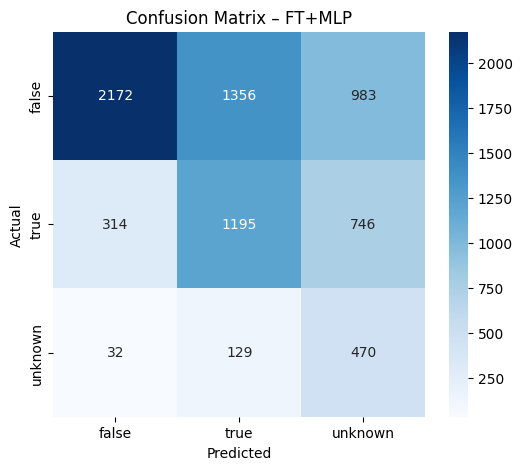

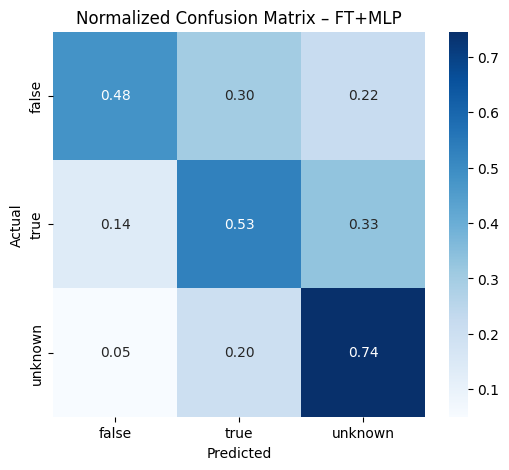

In [ ]:
cm_ft = plot_confusion(
    y_true=test_labels,
    probs=test_probs,
    title="Confusion Matrix – FT+MLP"
)

cm_ft_norm = plot_confusion(
    y_true=test_labels,
    probs=test_probs,
    normalize=True,
    title="Normalized Confusion Matrix – FT+MLP"
)

In [ ]:
errors_FT_MLP_test = make_error_table(
    probs=test_probs,
    y_true=test_labels,
    texts=test_df[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_langs,
    split_name="test",
    model_name="FastText+MLP"
)

In [ ]:
FT_MLP_errors_path = os.path.join(output_dir, "x_fact_c_e_FT_MLP_test_errors.csv")
errors_FT_MLP_test.to_csv(FT_MLP_errors_path, index=False)

print("Saved FT+MLP test errors to:", FT_MLP_errors_path)

In [ ]:
errors_FT_MLP_test.head()

,idx,text,actual,pred,conf,language,split,model,p_false,p_true,p_unknown
0,4,„უნივერსიტეტებს დამოუკიდებლობა ეზღუდებათ“ [SEP...,unknown,true,0.442260,ka,test,FastText+MLP,0.224584,0.442260,0.333157
1,6,"„უკვე ვასრულებთ ქალაქის გზების მოწესრიგებას, ე...",false,true,0.391060,ka,test,FastText+MLP,0.237907,0.391060,0.371032
2,8,„სტატისტიკის დეპარტამენტის მონაცემების მიხედვი...,false,true,0.415541,ka,test,FastText+MLP,0.222801,0.415541,0.361659
3,10,„სექტემბრიდან ათასობით ოჯახი [შშმ ბავშვები] ელ...,false,true,0.485373,ka,test,FastText+MLP,0.192130,0.485373,0.322497
4,11,„სამუშაო ადგილების რაოდენობა 2013 წლის პირველ ...,false,true,0.545806,ka,test,FastText+MLP,0.171383,0.545806,0.282811


In [ ]:
print("Total misclassified examples:", len(errors_FT_MLP_test))

Total misclassified examples: 3560


In [ ]:
show_errors(errors_FT_MLP_test, actual_label="unknown", pred_label="false", k=5)
show_errors(errors_FT_MLP_test, actual_label="unknown", pred_label="true",  k=5)
show_errors(errors_FT_MLP_test, actual_label="true",    pred_label="false", k=5)


=== 32 examples where actual=unknown, pred=false ===

[idx=5542] conf=0.875
LANG: ar
TEXT: امرأة مسنة يمنية ماتت دون أن يسأل عنها أحد، ومرّ على موتها شهور. في رواية أخرى تم العثور على امرأة سورية من ادلب تعيش وحدها في اسطنبول ميتة في منزلها. وقال البعض أن المرأة ميتة في منزلها منذ أكثر من عام في مدينة إدلب السورية. [SEP] mar 10, 2020 — الادعاء. امرأة مسنة يمنية ماتت دون أن يسأل عنها أحد، ومرّ على موتها شهور. في رواية أخرى تم العثور على امرأة سورية من ادلب تعيش وحدها في اسطنبول ميتة في منزلها. وقال البعض أن المرأة ميتة في منزلها منذ أكثر من عام في مدينة إدلب السورية. [SEP] oct 4, 2020 — مواقع أخرى: ... ويمتد الجدار العازل على الحدود المشتركة من محافظة إدلب شمال سورية حتى جبال ... مخاطر وتكاليف تهريب اللاجئين الباحثين عن الأمان وأبسط مقومات الحياة وفق ما ... إلى الحدود السورية التركية، تم وضعي مع أطفالي الأربعة وزوجي في منزل، ... خاصة من المعبر دون أن يعترضها أحد من حرس الحدود، كون الجميع حصلوا على ... [SEP] see what techno syria (technosyria7) has discovered on pinterest, the world's .

## **Fine-Tuning XLM-RoBERTa**

The final baseline uses a **transformer-based model**, `xlm-roberta-base`, fine-tuned on the X-fact dataset.

1. **HuggingFace Dataset Conversion**

   * The cleaned pandas DataFrames are converted into HuggingFace `Dataset` objects with the following fields:

     * `text` – the claim + 5 evidences,
     * `labels` – the encoded veracity label.

2. **Tokenization**

   * The XLM-R tokenizer is applied with:

     * `max_length = 512`,
     * `padding = "max_length"`,
     * `truncation = True`.
   * Each instance is transformed into `(input_ids, attention_mask, labels)` in PyTorch format.

3. **Model and Training Setup**

   * The base architecture is `xlm-roberta-base`, loaded through `AutoModelForSequenceClassification` with a classification head for 3 labels.
   * A custom `WeightedTrainer` is used, which:

     * applies **class weights** within the cross-entropy loss,
     * computes evaluation metrics such as accuracy, macro-F1, macro/micro AUPRC, and ECE during training.
   * Training arguments include:

     * `learning_rate = 2e-5`,
     * `batch_size = 16`,
     * `num_train_epochs = 5`,
     * `warmup_ratio = 0.1`,
     * `weight_decay = 0.01`,
     * evaluation performed at the end of each epoch.

4. **Evaluation**

   - After fine-tuning, the model is evaluated on the train, validation, and test splits using the shared evaluation utilities.
   - Confusion matrices and detailed error tables are generated for the misclassified test examples.

This setup enables direct comparison between **lexical**, **shallow neural**, and **transformer-based** approaches under a unified evaluation framework.


**Build HuggingFace Dataset objects from the cleaned dataframes**

In [ ]:
train_hf = HfDataset.from_pandas(train_df[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))
val_hf = HfDataset.from_pandas(val_df[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))
test_hf = HfDataset.from_pandas(test_df[[TEXT_COL, "labels"]].rename(columns={TEXT_COL: "text"}))

In [ ]:
print(train_hf[1])

{'text': '" \'denali\' is the kenyan word for \'black power.\' " [SEP] aug 30, 2015 ... second, “denali” does not mean “black power” in either english or swahili. the  word for black in swahili is “mweusi” and the word for power is\xa0... [SEP] sep 1, 2015 ... we need a black power mountain ... a meme spread across facebook timelines  alleging that “denali” was a “kenyan word” for black power. [SEP] sep 3, 2015 ... soon after, a meme began circulating on social media claiming denali as the  kenyan word for “black power.” the meme\'s false but viral\xa0... [SEP] sep 3, 2015 ... and then there was the internet rumor that “denali” was the “kenyan” word for  black power (it isn\'t), not to mention an anagram for “denial,”\xa0... [SEP] sep 1, 2015 ... after the white house announced it would change the name of mt. mckinley,  conservatives spread a meme claiming "denali" was a kenyan\xa0...', 'labels': 0}


**Tokenizer and encodings**

In [ ]:
MODEL_NAME = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

**Input length analysis for selecting the proper max_length**

In [ ]:
def token_length_stats(texts, tokenizer):
    lens = []
    for t in tqdm(texts):
        lens.append(len(tokenizer(t, truncation=False)["input_ids"]))
    lens = np.array(lens)
    print("Token length stats:")
    print("  mean:", lens.mean().round(1))
    print("  90% :", np.percentile(lens, 90).round(1))
    print("  95% :", np.percentile(lens, 95).round(1))
    print("  max :", lens.max())
    return lens

lens = token_length_stats(train_df[TEXT_COL].tolist(), tokenizer)


100%|██████████| 25892/25892 [00:36<00:00, 715.50it/s]


Token length stats:
  mean: 325.2
  90% : 443.0
  95% : 462.0
  max : 2369


In [ ]:
def tokenize(batch):
  return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )


train_encodings = train_hf.map(tokenize, batched=True)
val_encodings = val_hf.map(tokenize, batched=True)
test_encodings = test_hf.map(tokenize, batched=True)


train_encodings.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_encodings.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_encodings.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/25892 [00:00<?, ? examples/s]

Map:   0%|          | 0/3682 [00:00<?, ? examples/s]

Map:   0%|          | 0/7397 [00:00<?, ? examples/s]

In [ ]:
print(train_encodings[0])

{'labels': tensor(0), 'input_ids': tensor([     0,      6, 245109, 100231,  10176,  34923,  23040,    509,  51592,
            23,  46337,   1484,     13,    678,     10,  21115,    111,  54470,
         32834,   1970,      7,      5,   8705,   6991,  40225,  24189,    442,
         58359,     90,     70,   7108,  49129,    136,   2412,     83, 207487,
             5,   2412,  93002,    604,   9351,    619,  17378,   2412,     83,
           775,    289,    333,   5128,    249,   1708,      5,   8705,   6991,
          1305,    903,  16186,     98,    756,    935,  94407,      5,   2347,
         32834,   1970,      7,   5154,   2412,    509,  14037,     23,     10,
         25550,  38162,   1295,  42555,  28449,      5,  11354,    186,   2412,
           831,   2046,    604,   6897,   4420,      5,      6, 113612,    378,
           294,  21290,    268,   9374,  24470,   3640,   3797,   8422,     63,
           110,      4,    903,  23040,  58954,     25,     18,    678,    242,
     

**Define model**

In [ ]:
num_labels = len(label2id)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
).to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metric_acc = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = metric_acc.compute(predictions=preds, references=labels)["accuracy"]
    macro_f1 = f1_score(labels, preds, average="macro")

    probs = torch.softmax(torch.tensor(logits), dim=-1).cpu().numpy()

    auprc_macro, auprc_micro = compute_auprc(probs, labels, class_ids=CLASS_IDS)
    ece = compute_ece(probs, labels, n_bins=15)

    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_auprc": auprc_macro,
        "micro_auprc": auprc_micro,
        "ece": ece,
    }

In [ ]:
def trainer_eval_with_report(trainer, dataset, split_name):
    out = trainer.predict(dataset)
    logits = out.predictions
    y_true = out.label_ids
    probs = torch.softmax(torch.tensor(logits), dim=-1).cpu().numpy()
    metrics, preds = evaluate_probs(
        probs, y_true,
        split_name,
        class_ids=CLASS_IDS,
        id2label=id2label,
        n_bins=15
    )
    return metrics, probs, y_true

In [ ]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss = F.cross_entropy(
            logits, labels,
            weight=self.class_weights.to(logits.device) if self.class_weights is not None else None
        )

        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/misinfo_project/bert_models/x-fact_c_e_xlmr",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=200,
    report_to="none",
    save_total_limit=1
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_encodings,
    eval_dataset=val_encodings,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_t
)

/tmp/ipython-input-844214281.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Auprc,Micro Auprc,Ece
1,0.906500,0.794996,0.543726,0.491517,0.534951,0.686813,0.152298
2,0.873400,0.796623,0.605106,0.535769,0.551131,0.732767,0.101917
3,0.765900,0.786858,0.615698,0.543917,0.585046,0.740400,0.122775
4,0.671400,0.914436,0.634709,0.552614,0.586423,0.738202,0.150616
5,0.516300,1.089478,0.637425,0.543047,0.585127,0.741969,0.187643


TrainOutput(global_step=8095, training_loss=0.7641100581300487, metrics={'train_runtime': 5720.2675, 'train_samples_per_second': 22.632, 'train_steps_per_second': 1.415, 'total_flos': 3.406266305906688e+16, 'train_loss': 0.7641100581300487, 'epoch': 5.0})

In [ ]:
metrics_val_xlmr  = trainer_eval_with_report(trainer, val_encodings,  "Validation (XLM-R)")
metrics_test_xlmr = trainer_eval_with_report(trainer, test_encodings, "Test (XLM-R)")


=== Validation (XLM-R) ===
Macro-F1     : 0.5526141762699102
Macro AUPRC  : 0.5864227696152886
Micro AUPRC  : 0.7382018172926554
ECE          : 0.15061557685500057

              precision    recall  f1-score   support

       false       0.86      0.61      0.72      2256
        true       0.51      0.72      0.60      1140
     unknown       0.28      0.45      0.34       286

    accuracy                           0.63      3682
   macro avg       0.55      0.59      0.55      3682
weighted avg       0.71      0.63      0.65      3682




=== Test (XLM-R) ===
Macro-F1     : 0.5490074695552906
Macro AUPRC  : 0.596987532056433
Micro AUPRC  : 0.7432279155987546
ECE          : 0.15088009566765662

              precision    recall  f1-score   support

       false       0.85      0.63      0.72      4511
        true       0.51      0.73      0.60      2255
     unknown       0.29      0.38      0.33       631

    accuracy                           0.64      7397
   macro avg       0.55      0.58      0.55      7397
weighted avg       0.70      0.64      0.65      7397



In [ ]:
test_output = trainer.predict(test_encodings)

logits_xlmr = test_output.predictions
test_labels_xlmr = test_output.label_ids
test_probs_xlmr = torch.softmax(torch.tensor(logits_xlmr), dim=-1).cpu().numpy()

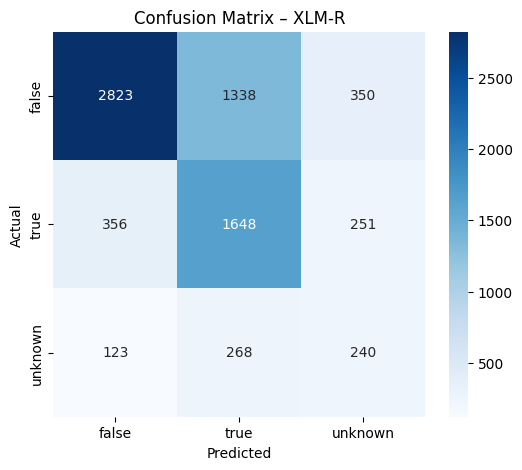

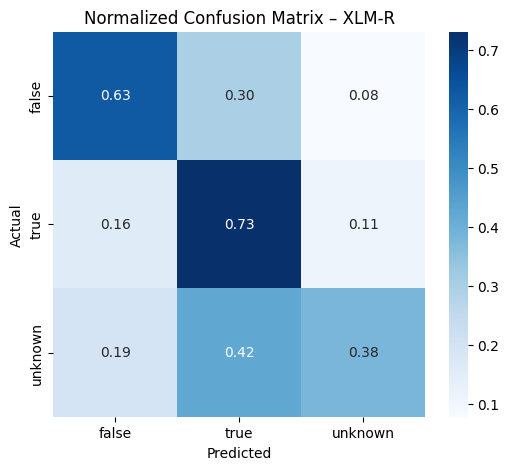

In [ ]:
cm_xlmr = plot_confusion(
    y_true=test_labels_xlmr,
    probs=test_probs_xlmr,
    title="Confusion Matrix – XLM-R"
)

cm_xlmr_norm = plot_confusion(
    y_true=test_labels_xlmr,
    probs=test_probs_xlmr,
    normalize=True,
    title="Normalized Confusion Matrix – XLM-R"
)

In [ ]:
test_langs = test_df[LANGUAGE_COL].tolist()

errors_xlmr_test = make_error_table(
    probs=test_probs_xlmr,
    y_true=test_labels_xlmr,
    texts=test_df[TEXT_COL].tolist(),
    class_ids=CLASS_IDS,
    id2label=id2label,
    languages=test_langs,
    split_name="test",
    model_name="XLM-R",
)

In [ ]:
errors_xlmr_test.head()

,idx,text,actual,pred,conf,language,split,model,p_false,p_true,p_unknown
0,3,"""$120,000 will be spent by taxpayers on charli...",true,false,0.445459,en,test,XLM-R,0.445459,0.378914,0.175627
1,5,"""$500 billion of the extension of the bush tax...",true,false,0.486508,en,test,XLM-R,0.486508,0.240185,0.273307
2,6,"""(birmingham, ala.) is the cradle of the civil...",false,true,0.415562,en,test,XLM-R,0.307355,0.415562,0.277083
3,8,"""(hillary clinton's state department) actually...",true,false,0.442179,en,test,XLM-R,0.442179,0.325774,0.232047
4,13,"""(ronald reagan) raised taxes a billion dollar...",true,unknown,0.464490,en,test,XLM-R,0.086172,0.449338,0.464490


In [ ]:
output_dir = "/content/drive/MyDrive/misinfo_project"
os.makedirs(output_dir, exist_ok=True)

XLMR_errors_path = os.path.join(output_dir, "x_fact_c_e_XLMR_test_errors.csv")
errors_xlmr_test.to_csv(XLMR_errors_path, index=False)

print("Saved XLMR test errors to:", XLMR_errors_path)

Saved XLMR test errors to: /content/drive/MyDrive/misinfo_project/x_fact_c_e_XLMR_test_errors.csv


## **Error Analysis Across Models**

To complement aggregate metrics, qualitative error analysis is conducted for all models.

* For each model (TF–IDF+NB, FastText+MLP, and XLM-R), the saved **test-set error tables** are loaded.
* The frequency of each misclassification pair `(actual_label → predicted_label)` is summarized.
* High-confidence errors—cases where the predicted probability is high but the prediction is incorrect—are inspected.
* Representative examples are examined for the most common confusion patterns (e.g., `unknown → true`, `true → false`).

This analysis helps identify:

* whether certain labels are systematically confused,
* whether high-confidence mistakes involve patterns such as **negation**, **subtle phrasing**, or **world-knowledge requirements**,
* and whether XLM-R reduces specific error types relative to the lexical or shallow neural baselines.





In [ ]:
def summarize_errors(df):
    print("\n=== Error Counts by (actual → pred) ===")
    print(df.groupby(["actual", "pred"]).size())

    if "language" in df.columns:
        print("\n=== Errors by language (counts) ===")
        lang_counts = df["language"].value_counts()
        print(lang_counts)

        print("\n=== Errors by language (percentage) ===")
        print((lang_counts / len(df) * 100).round(2).astype(str) + "%")

    print("\n=== Top 10 high-confidence wrong predictions ===")
    print(
        df.sort_values("conf", ascending=False)
          .head(10)[["idx", "text", "actual", "pred", "conf", "language"]]
    )

In [ ]:
def inspect_top_error_pairs(df, top_n=3, k=5):
    pair_counts = (
        df.groupby(["actual", "pred"]).size()
          .sort_values(ascending=False)
          .head(top_n)
    )

    print("\nTop error pairs:")
    print(pair_counts)

    for (actual, pred), _ in pair_counts.items():
        show_errors(df, actual_label=actual, pred_label=pred, k=k)


In [ ]:
errors_nb_test = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_c_e_nb_test_errors.csv")
errors_ft_test = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_c_e_FT_MLP_test_errors.csv")
errors_xlmr_test = pd.read_csv("/content/drive/MyDrive/misinfo_project/x_fact_c_e_XLMR_test_errors.csv")

In [ ]:
print("Total misclassified examples for NB:", len(errors_nb_test))
print("Total misclassified examples for FT+MLP:", len(errors_ft_test))
print("Total misclassified examples for XLM-R:", len(errors_xlmr_test))

Total misclassified examples for NB: 3148
Total misclassified examples for FT+MLP: 3560
Total misclassified examples for XLM-R: 2686


In [ ]:
summarize_errors(errors_nb_test)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       1065
         unknown     522
true     false       685
         unknown     291
unknown  false       102
         true        300
dtype: int64

=== Errors by language (counts) ===
language
en    1484
pt     544
ka     202
pl     145
es     144
it     116
tr     105
ro      68
ta      67
id      36
sr      25
ar      16
de      13
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
en    50.05%
pt    18.35%
ka     6.81%
pl     4.89%
es     4.86%
it     3.91%
tr     3.54%
ro     2.29%
ta     2.26%
id     1.21%
sr     0.84%
ar     0.54%
de     0.44%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
       idx                                               text   actual   pred  \
2486  5483  الرئيس التركي، رجب طيب أردوغان، يعلن نجاح بلاد...     true  false   
2487  5504  امرأة مسنة يمنية ماتت دون أن يسأل عنها أحد، وم...  unknown  false   
2134  4566  schwangere wi

In [ ]:
inspect_top_error_pairs(errors_nb_test, top_n=3, k=5)


Top error pairs:
actual  pred   
false   unknown    908
        true       855
true    false      636
dtype: int64

=== 908 examples where actual=false, pred=unknown ===

[idx=236] conf=0.640
LANG: en
TEXT: "earlier this year, the head of the congressional budget office testified before congress that implementation of obamacare would cost 800,000 jobs." [SEP] despite promising to lower costs, the president's failed health care policies have  left families, ... reports the cost of a family health care plan spiked 9 percent just  last year, ... to implement obamacare and an additional $111 billion to finance  the law's ... office (cbo) estimates the law will lead to 800,000 fewer jobs by  2021. [SEP] jun 8, 2011 ... former state house majority leader adam hasner, now running in a crowded  republican primary to challenge democratic u.s. sen. bill nelson in ... earlier  this year, the head of the congressional budget office testified before congress  that implementation of obamacare would

In [ ]:
summarize_errors(errors_ft_test)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       1356
         unknown     983
true     false       314
         unknown     746
unknown  false        32
         true        129
dtype: int64

=== Errors by language (counts) ===
language
en    1773
pt     749
ka     201
es     144
pl     144
ta     129
it     125
tr     114
ro      82
id      40
sr      25
ar      18
de      16
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
en     49.8%
pt    21.04%
ka     5.65%
es     4.04%
pl     4.04%
ta     3.62%
it     3.51%
tr      3.2%
ro      2.3%
id     1.12%
sr      0.7%
ar     0.51%
de     0.45%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
       idx                                               text actual   pred  \
197    297  "foto wanita iran yang menonton piala dunia ta...   true  false   
1967  3648  pbnu tidak pernah menuding pemerintah mengguna...   true  false   
2851  5119  video viral polisi 

In [ ]:
inspect_top_error_pairs(errors_ft_test, top_n=3, k=5)


Top error pairs:
actual  pred   
false   true       1356
        unknown     983
true    unknown     746
dtype: int64

=== 1356 examples where actual=false, pred=true ===

[idx=5357] conf=0.729
LANG: it
TEXT: «l’italia in questo momento nelle scuole ha il 3,5 per cento di focolai. in francia abbiamo il 32 per cento nelle scuole» (min. 9:04) [SEP] «l’italia in questo momento nelle scuole ha il 3,5 per cento di focolai. in francia abbiamo il 32 per cento nelle scuole» (min. 9:04) [SEP] oct 27, 2020 — alleanza gsk-sanofi per produrre 200 milioni di dosi di vaccino○ cdc: ... il focolaio più recente nel carcere di terni, dove sono 55 i positivi (quasi ... “nelle scuole primarie abbiamo numeri pesantissimi, restano ... la commissione europea ha deciso di mobilitare cento milioni di euro attraverso il fondo per ... [SEP] sep 15, 2020 — trump, alcuni pensano mascherine non siano utili, vaccino in 3-4 settimane ... inoltre, il funzionario ha riferito che nelle ultime 24 ore sono stati rilevati

In [ ]:
summarize_errors(errors_xlmr_test)


=== Error Counts by (actual → pred) ===
actual   pred   
false    true       1338
         unknown     350
true     false       356
         unknown     251
unknown  false       123
         true        268
dtype: int64

=== Errors by language (counts) ===
language
en    1224
pt     574
ka     205
pl     138
it     106
tr      98
ro      89
es      80
ta      72
de      33
sr      31
id      20
ar      16
Name: count, dtype: int64

=== Errors by language (percentage) ===
language
en    45.57%
pt    21.37%
ka     7.63%
pl     5.14%
it     3.95%
tr     3.65%
ro     3.31%
es     2.98%
ta     2.68%
de     1.23%
sr     1.15%
id     0.74%
ar      0.6%
Name: count, dtype: object

=== Top 10 high-confidence wrong predictions ===
       idx                                               text actual   pred  \
1322  3217  mus mulyadi musisi keroncong indonesia tutup u...   true  false   
2499  6794  “kabareskrim usut situs palsu catut namanya” [...   true  false   
1121  2699  foto: „steinmeier m

In [ ]:
inspect_top_error_pairs(errors_xlmr_test, top_n=3, k=5)


Top error pairs:
actual  pred   
false   true       1338
true    false       356
false   unknown     350
dtype: int64

=== 1338 examples where actual=false, pred=true ===

[idx=3050] conf=0.978
LANG: id
TEXT: klarifikasi kenapa muncul foto amien rais saat cari 'setan' di google? [SEP] info #klarifikasi kenapa muncul #foto #amien #rais saat cari '#setan' di #google? media sosial kembali heboh oleh hal yang tidak berfaedah. belakangan... [SEP] belakangan ini, warga twitter ramai membicarakan keluarnya foto politisi amien rais di mesin pencarian google saat orang-orang memasukkan kata kunci ... [SEP] klarifikasi kenapa muncul foto amien rais saat cari 'setan' di google? [SEP] jun 20, 2018 — keluar foto amien rais saat dimasukkan kata kunci "setan" di mesin pencari google. kenapa bisa begitu? [SEP] jun 21, 2018 — ketika memasukkan kata kunci 'setan' di mesin pencarian google, yang ... muncul foto amien rais saat cari 'setan' di google ... muncul video syur mirip anya geraldine setelah gis